In [1]:
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rama1703","key":"e739821a56c9e3a6ad2e3cdcb5ebbe08"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d zalando-research/fashionmnist
!unzip fashionmnist.zip -d data/fashion-mnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
Archive:  fashionmnist.zip
checkdir:  cannot create extraction directory: data/fashion-mnist
           No such file or directory


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader

# ✅ Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ Load Dataset
trainset = torchvision.datasets.FashionMNIST(root='./data/fashion-mnist', train=True,
                                              download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# ✅ Model
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Training Loop
for epoch in range(5):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss/len(trainloader):.4f}")

# ✅ Save Model
torch.save(model.state_dict(), '/content/resnet_fashionmnist.pt')

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.9MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:

Epoch 1 Loss: 0.3010
Epoch 2 Loss: 0.2044
Epoch 3 Loss: 0.1711
Epoch 4 Loss: 0.1419
Epoch 5 Loss: 0.1195


Validation Accuracy = 93.11%

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.92      0.89      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.92      0.90      1000
       Dress       0.93      0.93      0.93      1000
        Coat       0.87      0.90      0.88      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.86      0.73      0.79      1000
     Sneaker       0.98      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.96      0.98      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



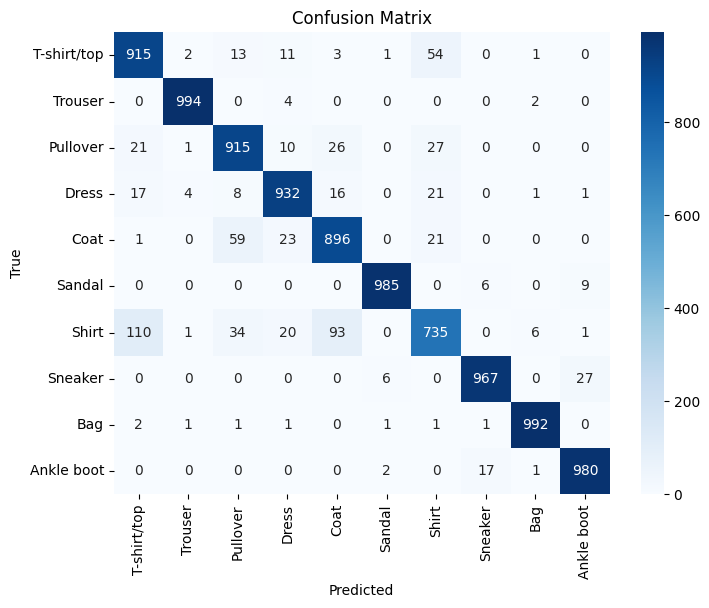

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ✅ Validation DataLoader
valset = torchvision.datasets.FashionMNIST(root='./data/fashion-mnist', train=False, download=True, transform=transform)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# ✅ Evaluate on Validation Set
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = correct / total
    return acc, all_preds, all_labels

val_acc, preds, labels = evaluate(model, valloader)
print(f"Validation Accuracy = {val_acc * 100:.2f}%")

# ✅ Classification Report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=trainset.classes))

# ✅ Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()